In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Monet using GAN

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

datapath = r'/kaggle/input/gan-getting-started'

Number of replicas: 1


In [2]:
if os.path.exists(r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'):
    datapath = r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'
else:
    datapath = r'C:\Users\nikok\Documents\Monet using GAN'

In [ ]:
print(tf.__version__)
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)


## Brief description of the problem and data (5 pts)

*Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.*

In [3]:
monet_files = os.listdir(os.path.join(datapath, 'monet_tfrec'))
photo_files = os.listdir(os.path.join(datapath, 'photo_tfrec'))
monet_filenames = [os.path.join(datapath, 'monet_tfrec', f) for f in monet_files]
photo_filenames = [os.path.join(datapath, 'photo_tfrec', f) for f in photo_files]
print(20*'*', 'Monet paintings', 20*'*')
print('First filename:', monet_files[0], '\nNumber of files:', len(monet_files))
print(20*'*', 'Photos', 20*'*')
print('First filename:', photo_files[0], '\nNumber of files:', len(photo_files))

******************** Monet paintings ********************
First filename: monet00-60.tfrec 
Number of files: 5
******************** Photos ********************
First filename: photo00-352.tfrec 
Number of files: 20


### Figure out the contents of the tfrec files

From the code below we can see that each record/example contains three fields: 
* target: label of the image. Not needed in this work 
* image_name: name of the image
* image: the actual image data

Both of the data sets appear to have the same structure. 

In [4]:
# The following code is adapted from an answer from Microsoft Copilot
import tensorflow as tf
from google.protobuf.json_format import MessageToJson
import json

def iterate_record(dataset):
    # Initialize a counter
    record_count = 0
    # Iterate through the dataset and count the records
    for _ in dataset:
        record_count += 1
    print(f'Total number of records: {record_count}')
    
    # Iterate through the dataset and parse each record
    for raw_record in dataset.take(1):  # Adjust the number to read more records
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        json_message = MessageToJson(example)
        parsed_record = json.loads(json_message)
        print(json.dumps(parsed_record, indent=2)[0:500])

# Create a TFRecordDataset
print(20*'*', 'Monet paintings', 20*'*')
raw_monet_dataset = tf.data.TFRecordDataset(monet_filenames)
iterate_record(raw_monet_dataset)

print(20*'*', 'Photos', 20*'*')
raw_photo_dataset = tf.data.TFRecordDataset(photo_filenames)
iterate_record(raw_photo_dataset)

******************** Monet paintings ********************
Total number of records: 300
{
  "features": {
    "feature": {
      "target": {
        "bytesList": {
          "value": [
            "bW9uZXQ="
          ]
        }
      },
      "image_name": {
        "bytesList": {
          "value": [
            "MjVjOTkwNDc4Mg=="
          ]
        }
      },
      "image": {
        "bytesList": {
          "value": [
            "/9j/4AAQSkZJRgABAQEBLAEsAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgo
******************** Photos ********************
Total number of records: 7038
{
  "features": {
    "feature": {
      "target": {
        "bytesList": {
          "value": [
            "cGhvdG8="
          ]
        }
      },
      "image_name": {
        "bytesList": {
          "value": [
            "MGI5MWYzNTljNQ=="
          ]
        }
      },
      "image": {
        "bytesList": {
          "val

We can parse the data now since the structure of the tfrecord is known.

In [5]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["image"] = (tf.cast(example["image"], tf.float32) / 127.5) - 1
    return example

def decode_image(tf_image):
    return ((tf_image['image'].numpy()[0] + 1) * 127.5).astype(int)


# monet_dataset = raw_monet_dataset.map(parse_tfrecord_fn)
monet_test_dataset = raw_monet_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
photo_test_dataset = raw_photo_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE).batch(1)


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

*Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?*

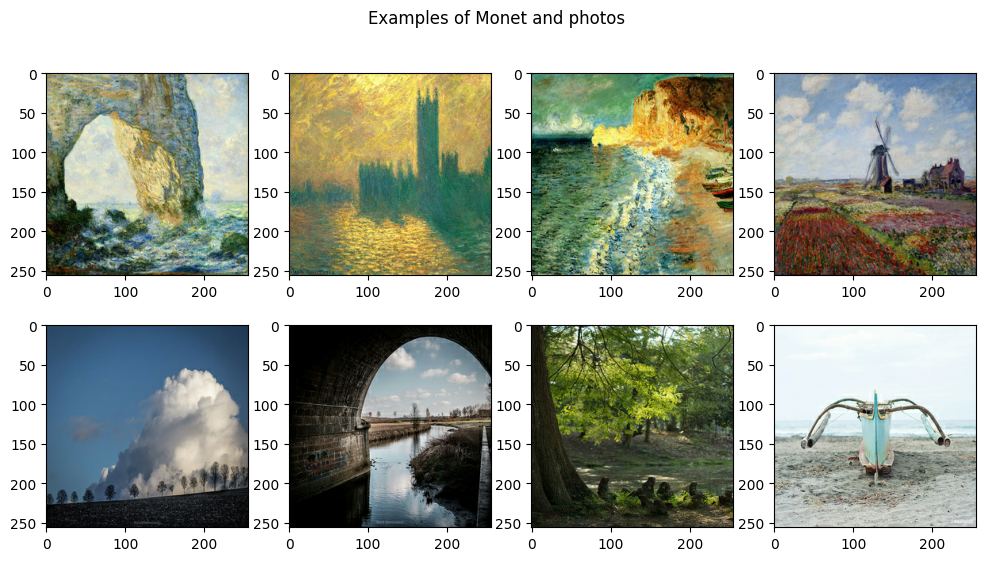

In [6]:
fig = plt.figure(figsize=(12, 6))
i = 0
for data in monet_test_dataset.take(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(decode_image(data))
    # print(data['image'].shape)
    i += 1
for data in photo_test_dataset.take(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(decode_image(data))
    i += 1
fig.suptitle('Examples of Monet and photos')
plt.show()

In [7]:
dims = []
for data in photo_test_dataset:
    img = data['image'].numpy().shape[1:]
    dims.append(img)
print('Unique shapes of the photos data:', set(dims))

dims = []
for data in monet_test_dataset:
    dims.append(data['image'].numpy().shape[1:])
print('Unique shapes of the Monet data:', set(dims))

Unique shapes of the photos data: {(256, 256, 3)}
Unique shapes of the Monet data: {(256, 256, 3)}


In [9]:
def plot_histogram(dataset, title):
    rgb = []
    for data in dataset:
        rgb.append(data['image'].numpy())
    rgb = np.array(rgb)
    # rgb.shape
    pic_channels = ['red', 'green', 'blue']
    rgb_df = pd.DataFrame()
    for i, clr in enumerate(pic_channels):
        df = pd.DataFrame(rgb[:,:,:,i].ravel(), columns=['val'])
        df['color'] = clr
        rgb_df = pd.concat([rgb_df, df])
    print('Minimum and maximmum values in ' + title + ' data: ', min(rgb_df.val), '&', max(rgb_df.val))
    sns.histplot(rgb_df.sample(1000), x='val', hue='color', bins=30, multiple='dodge', color=['green', 'blue', 'red'])
    plt.grid()
    plt.title('Histogram of ' + title)
    plt.show()



Minimum and maximmum values in sample photos data:  -1.0 & 1.0


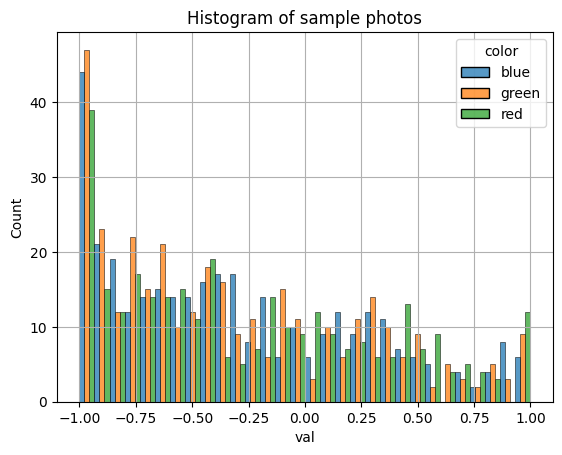

Minimum and maximmum values in Monet paintings data:  -1.0 & 1.0


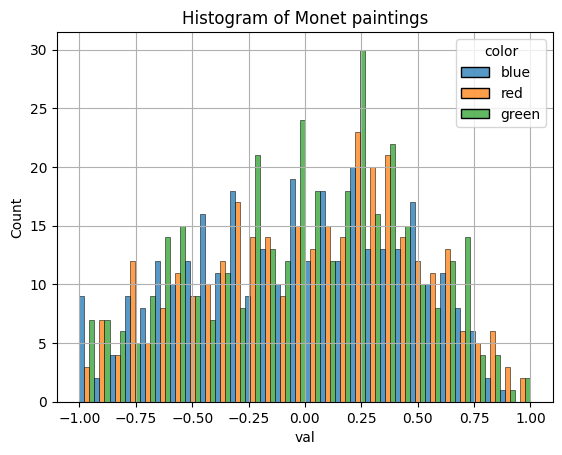

In [11]:
plot_histogram(photo_test_dataset.take(300), title='sample photos')
plot_histogram(monet_test_dataset, title='Monet paintings')


After the EDA is done, we set the batch size of the dataset for training.

In [19]:
def configure_for_performance(ds, BATCH_SIZE):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  # batch_size = 35
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  ds = ds.repeat()
  return ds

BATCH_SIZE = 32#16 * tpu_strategy.num_replicas_in_sync
print(BATCH_SIZE)
monet_dataset = raw_monet_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)#.batch(BATCH_SIZE, drop_remainder=True)
photo_dataset = raw_photo_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)#.batch(BATCH_SIZE, drop_remainder=True)
# monet_dataset = configure_for_performance(monet_dataset, BATCH_SIZE)
# photo_dataset = configure_for_performance(photo_dataset, BATCH_SIZE)
monet_dataset = monet_dataset.shuffle(buffer_size=7000).repeat().cache()
photo_dataset = photo_dataset.shuffle(buffer_size=7000).repeat().cache()
monet_dataset = monet_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
photo_dataset = photo_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


32


## Model Architecture

In [9]:
# with tpu_strategy.scope():
def discriminator():
    discriminator= keras.Sequential(
        [
            keras.Input(shape=(256, 256, 3)),
            layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator")
    return discriminator

my_discriminator = discriminator()
my_discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528,961 (2.02 MB)

 Trainable params: 528,321 (2.02 MB)

 Non-trainable params: 640 (2.50 KB)

In [10]:
# with tpu_strategy.scope():
def discriminator_lite():
    discriminator= keras.Sequential(
        [
            keras.Input(shape=(256, 256, 3)),
            layers.Conv2D(32, kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator")
    return discriminator

discriminator_lite = discriminator_lite()
discriminator_lite.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        65,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,177 (649.13 KB)

 Trainable params: 165,857 (647.88 KB)

 Non-trainable params: 320 (1.25 KB)

In [22]:
def generator(latent_dim=128):
    generator = keras.Sequential(
        [
            keras.Input(shape=(latent_dim,)),
            layers.Dense(8 * 8 * 128),
            layers.Reshape((8, 8, 128)),
            layers.Conv2DTranspose(int(0.125*128), kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(0.125*256), kernel_size=4, strides=4, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(0.125*512), kernel_size=4, strides=4, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
        ],
        name="generator")
    return generator
latent_dim = 128
generator = generator(latent_dim)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 16, 16, 16)     │        32,784 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 64, 64, 32)     │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 256, 256, 64)   │        32,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 3)    │         4,803 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,135,411 (4.33 MB)

 Trainable params: 1,135,411 (4.33 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# with tpu_strategy.scope():
def generator_from_img(latent_dim=128):
    stddev = 0.1
    lite_factor = 1
    generator = keras.Sequential(
        [
            keras.Input(shape=(256,256,3)),
            layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(512 * lite_factor), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(256 * lite_factor), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(128 * lite_factor), kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(128 * lite_factor), kernel_size=4, strides=8, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            # layers.Reshape((8, 8, latent_dim)),
            # layers.Dropout(0.2),
            layers.Flatten(),
            # layers.GaussianNoise(stddev, seed=123),
            # layers.Dense(8 * 8 * 128),
            layers.Reshape((1, 1, 128)),
            layers.Conv2DTranspose(int(128 * lite_factor), kernel_size=4, strides=8, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(128 * lite_factor), kernel_size=4, strides=2, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(256 * lite_factor), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(512 * lite_factor), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
        ],
        name="generator_from_img")
    return generator
generator_from_img = generator_from_img(latent_dim)
generator_from_img.summary()

Model: "generator_from_img"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 3)    │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256, 256, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 512)    │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 256)    │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 128)      │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │             

 Total params: 6,102,771 (23.28 MB)

 Trainable params: 6,098,669 (23.26 MB)

 Non-trainable params: 4,102 (16.02 KB)

### keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding="valid",...)
    

* filters: int, the dimension of the output space (the number of filters in the convolution).
* kernel_size: int or tuple/list of 2 integer, specifying the size of the convolution window.
* strides: int or tuple/list of 2 integer, specifying the stride length of the convolution. strides > 1 is incompatible with dilation_rate > 1.
* padding: string, either "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.

Source: https://keras.io/api/layers/convolution_layers/convolution2d/

In [13]:
# with tpu_strategy.scope():
def generator_from_img_lite(latent_dim=128):
    stddev = 0.1
    lite_factor = 0.125
    generator = keras.Sequential(
        [
            keras.Input(shape=(256,256,3)),
            layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(512 * lite_factor), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(256 * lite_factor), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(int(64 * lite_factor), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            # layers.Conv2D(int(128 * lite_factor), kernel_size=4, strides=4, padding="same"),
            # layers.BatchNormalization(axis=-1),
            # layers.LeakyReLU(negative_slope=0.2),
            # layers.Reshape((8, 8, latent_dim)),
            # layers.Dropout(0.2),
            layers.Flatten(),
            # layers.GaussianNoise(stddev, seed=123),
            # layers.Dense(8 * 8 * 128),
            layers.Reshape((1, 1, 128)),
            layers.Conv2DTranspose(int(64 * lite_factor), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(256 * lite_factor), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(512 * lite_factor), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(int(512 * lite_factor), kernel_size=4, strides=4, padding="same"),
            layers.BatchNormalization(axis=-1),
            layers.LeakyReLU(negative_slope=0.2),
            # layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
            layers.Conv2D(3, (7, 7), padding="same"),
            layers.Activation("tanh"),
        ],
        name="generator_from_img_lite")
    return generator
generator_from_img_lite = generator_from_img_lite(latent_dim)
generator_from_img_lite.summary()

Model: "generator_from_img_lite"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 3)    │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256, 256, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 8)        │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 4, 4, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 4, 4, 8)        │        16,392 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 4, 4, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 16, 16, 32)     │         4,128 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 64, 64, 64)     │        32,83

 Total params: 169,731 (663.01 KB)

 Trainable params: 169,181 (660.86 KB)

 Non-trainable params: 550 (2.15 KB)

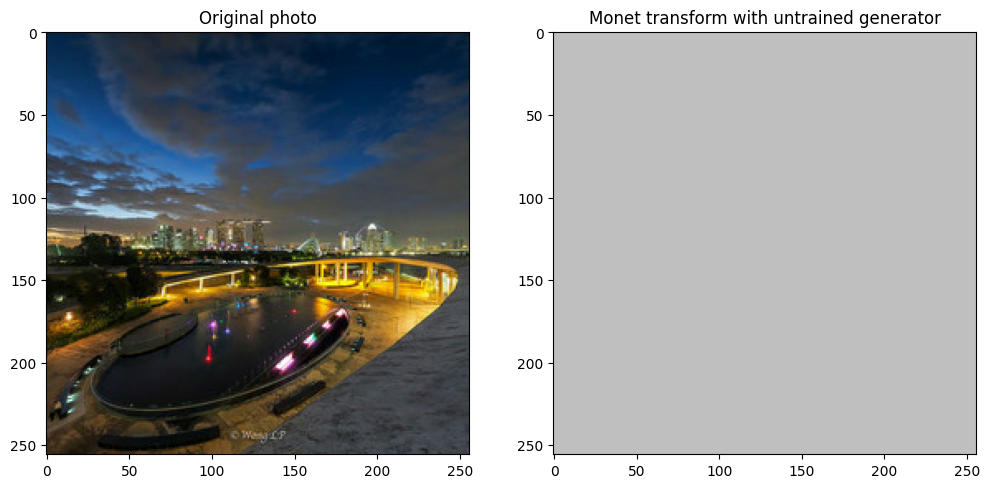

In [14]:
for photo in photo_dataset.take(1):
    generated_images = generator_from_img(photo['image'])
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 2, 1)
plt.imshow(decode_image(photo))
plt.title('Original photo')
ax = plt.subplot(1, 2, 2)
# plt.show()
plt.imshow(((generated_images.numpy()[0] + 1) * 127.5).astype(int))
plt.title('Monet transform with untrained generator')
plt.show()


### Basic DCGAN

In [15]:
# with tpu_strategy.scope():
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, image_batches):
        monet_images, photo_images = image_batches
        monet_images = monet_images['image']
        photo_images = photo_images['image']
        batch_size = keras.ops.shape(monet_images)[0]
        
        # Decode photos to fake Monets
        generated_images = self.generator(photo_images)

        # Combine them with real images
        combined_images = keras.ops.concatenate([generated_images, monet_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = keras.ops.concatenate(
            [keras.ops.ones((batch_size, 1)), keras.ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # # Sample random points in the latent space
        # random_latent_vectors = keras.random.normal(
        #     shape=(batch_size, self.latent_dim), seed=self.seed_generator
        # )

        # Assemble labels that say "all real images"
        misleading_labels = keras.ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(photo_images))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [20]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, test_photo=None):
        self.num_img = num_img
        self.test_photo = test_photo

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.test_photo)
        generated_images = ((generated_images.numpy()[0] + 1) * 127.5).astype(int)
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


In [21]:
epochs = 5  # In practice, use ~100 epochs

# instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():
gan = GAN(discriminator=my_discriminator, generator=generator_from_img_lite, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
num_img=10
for photo in photo_dataset.take(num_img):
    test_photo = photo['image']
gan.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)), epochs=epochs, callbacks=[GANMonitor(num_img=10, test_photo=test_photo)]
)

Epoch 1/5


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data_3:0", shape=(None, None, 3), dtype=float32). Expected shape (None, 256, 256, 3), but input has incompatible shape (None, None, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None, 3), dtype=float32)
  • training=None
  • mask=None

### Cycle DCGAN

In [35]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }